In [1]:
# PMCMC for linearized DSGE models
# Author: Takeki Sunakawa
# Mail: takeki.sunakawa@gmail.com
# Last updated: April 19, 2019 @ Tsutaya book store, Umeda Lucua 1010
# Last updated: April 20, 2019 @ Cafe de Crie, Kobe Motomachi

using DelimitedFiles
using Random
using ControlSystems # not in CoCalc
using Distributions # not in CoCalc
using PDMats # not in CoCalc
using StatsBase # not in CoCalc
using Plots
using KernelDensity
using SpecialFunctions
using Printf
using Optim
using SparseArrays
# using CsminWel
include("gensys.jl")

new_div (generic function with 1 method)

In [2]:
# function inbounds(para)

#     npara = 13
#     bounds = zeros(npara,2)
#     bounds[1,:]  = [0 100.0]
#     bounds[2,:]  = [0 100.0]
#     bounds[3,:]  = [0 100.0]
#     bounds[4,:]  = [0 100.0]
#     bounds[5,:]  = [0 100.0]
#     bounds[6,:]  = [0 100.0]
#     bounds[7,:]  = [0 100.0]
#     bounds[8,:] = [0 1.0]
#     bounds[9,:] = [0 1.0]
#     bounds[10,:] = [0 1.0]
#     bounds[11,:] = [0 100.0]
#     bounds[12,:] = [0 100.0]
#     bounds[13,:] = [0 100.0]

#     flag = true
#     for j=1:npara

#         if ( (para[j]<bounds[j,1]) || (para[j]>bounds[j,2]) )

#             flag = false
# #             println(@sprintf("parameter %2d was out of bounds",j))
# # 
# #             if (para[j]<bounds[j,1])
# #                 println(@sprintf("%10.5f < %10.5f",para[j],bounds[j,1]))
# #             else
# #                 println(@sprintf("%10.5f > %10.5f",para[j],bounds[j,2]))
# #             end

#         end

#     end

#     return flag

# end

In [3]:
function model_solution(para)

# Theta = [tau kappa psi1 psi2 rA piA gammaQ rho_R rho_g rho_z sigma_R sigma_g sigma_z]
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]
    sigma_g = para[12]
    sigma_z = para[13]
    bet = 1/(1+rA/400)

    # Equation indices

    eq_1   = 1  #** (2.1) on \hat{y}(t) **/
    eq_2   = 2  #** (2.1) on \hat{pi}(t) **/
    eq_3   = 3  #** (2.1) on \hat{R}(t) **/
    eq_4   = 4  #** \hat{y}(t-1) **/
    eq_5   = 5  #** \hat{g} process **/
    eq_6   = 6  #** \hat{z} process **/
    eq_7   = 7  #** \hat{y} expectational error **/
    eq_8   = 8  #** \hat{pi} expectational error **/

    # Variable indices 

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # Expectation error indices (eta) 

    ey_sh  = 1
    epi_sh = 2       

    # Shock indices (eps)

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # SUMMARY

    neq  = 8
    neta = 2
    neps = 3

    # /** initialize matrices **/

    GAM0 = zeros(neq,neq)
    GAM1 = zeros(neq,neq)
       C = zeros(neq,1)        
     PSI = zeros(neq,neps)
     PPI = zeros(neq,neta)


    # =========================================================================
    #                 EQUILIBRIUM CONDITIONS: CANONICAL SYSTEM
    # =========================================================================

    # =========================================================================
    #          1. 
    # =========================================================================

    GAM0[eq_1,y_t] =  1
    GAM0[eq_1,R_t] =  1/tau
    GAM0[eq_1,g_t] = -(1-rho_g)
    GAM0[eq_1,z_t] = -rho_z/tau
    GAM0[eq_1,Ey_t1] = -1
    GAM0[eq_1,Epi_t1] = -1/tau

    # =========================================================================
    #          2. 
    # =========================================================================

    GAM0[eq_2,y_t] = -kappa;
    GAM0[eq_2,pi_t] = 1;
    GAM0[eq_2,g_t] =  kappa;
    GAM0[eq_2,Epi_t1] = -bet;

    # =========================================================================
    #          3. 
    # =========================================================================

    GAM0[eq_3,y_t] = -(1-rho_R)*psi2
    GAM0[eq_3,pi_t] = -(1-rho_R)*psi1
    GAM0[eq_3,R_t] = 1
    GAM0[eq_3,g_t] = (1-rho_R)*psi2
    GAM1[eq_3,R_t] = rho_R
    PSI[eq_3,R_sh] = 1

    # =========================================================================
    #          4. 
    # =========================================================================

    GAM0[eq_4,y1_t] = 1
    GAM1[eq_4,y_t] = 1

    # =========================================================================
    #          5. 
    # =========================================================================

    GAM0[eq_5,g_t] = 1
    GAM1[eq_5,g_t] = rho_g
    PSI[eq_5,g_sh] = 1

    # =========================================================================
    #          6. 
    # =========================================================================

    GAM0[eq_6,z_t] = 1
    GAM1[eq_6,z_t] = rho_z
    PSI[eq_6,z_sh] = 1

    # =========================================================================
    #          7. 
    # =========================================================================

    GAM0[eq_7,y_t] = 1
    GAM1[eq_7,Ey_t1] = 1
    PPI[eq_7,ey_sh] = 1

    # =========================================================================
    #          8. 
    # =========================================================================

    GAM0[eq_8,pi_t] = 1
    GAM1[eq_8,Epi_t1] = 1
    PPI[eq_8,epi_sh] = 1


    # =========================================================================
    #            QZ(generalized Schur) decomposition by GENSYS
    # =========================================================================

    T1, TC, T0, fmat, fwt, ywt, gev, eu, loose = gensys(GAM0,GAM1,C,PSI,PPI)

    return T1, T0

end

model_solution (generic function with 1 method)

In [4]:
function sysmat(T1,T0,para)

# Theta = [tau kappa psi1 psi2 rA piA gammaQ rho_R rho_g rho_z sigma_R sigma_g sigma_z]
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]
    sigma_g = para[12]
    sigma_z = para[13]
    
    eq_y = 1
    eq_pi = 2
    eq_ffr = 3

    # /** number of observation variables **/

    ny = 3

    # /** model variable indices **/

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # /** shock indices **/

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # =========================================================================
    #                           TRANSITION EQUATION
    #    
    #            s(t) = Phi*s(t-1) + R*e(t)
    #            e(t) ~ iid N(0,Se)
    #  
    # =========================================================================

    nep = size(T0,2)

    Phi = T1

    R   = T0

    Se  = zeros(nep,nep)

    Se[z_sh,z_sh] = (sigma_z)^2
    Se[g_sh,g_sh] = (sigma_g)^2
    Se[R_sh,R_sh] = (sigma_R)^2

    # =========================================================================
    #                           MEASUREMENT EQUATION
    #   
    #            y(t) = a + b*s(t) + u(t) 
    #            u(t) ~ N(0,HH)
    #  
    # =========================================================================

    A           = zeros(ny,1)
    A[eq_y,1]   = gammaQ
    A[eq_pi,1]  = piA
    A[eq_ffr,1] = piA+rA+4*gammaQ

    nstate = size(Phi,2)

    B = zeros(ny,nstate)

    B[eq_y,y_t]   = 1
    B[eq_y,y1_t]  = -1 
    B[eq_y, z_t]  = 1
    B[eq_pi,pi_t] = 4
    B[eq_ffr,R_t] = 4

    H = zeros(ny,ny)
    # with measurement errors (from dsge1_me.yaml)
    H[eq_y,y_t] = (0.20*0.579923)^2
    H[eq_pi,pi_t] = (0.20*1.470832)^2
    H[eq_ffr,R_t] = (0.20*2.237937)^2
    
    return A,B,H,R,Se,Phi

end    

sysmat (generic function with 1 method)

In [5]:
function nearestSPD(A)

    # symmetrize A into B
    B = (A + A')/2

    # Compute the symmetric polar factor of B. Call it H.
    # Clearly H is itself SPD.
    U,Sigma,V = svd(B)
    H = V*diagm(0=>Sigma)*V'

    # get Ahat in the above formula
    Ahat = (B+H)/2

    # ensure symmetry
    Ahat = (Ahat + Ahat')/2

    p = 1
    k = 0

    while (p != 0) 
        p = 0
        try
            R = cholesky(Ahat)
        catch
            p = 1
        end    

        if (p != 0)
            k = k + 1
            mineig = -maximum(-eigvals(Ahat))
            Ahat = Ahat + (-mineig*k^2 + eps(mineig))*Matrix(1.0I,size(A,1),size(A,1))
        end

    end

    return Ahat
end

nearestSPD (generic function with 1 method)

In [6]:
function PF(A, B, H, Phi, R, S2, N, yt, x0, P0, resample)

    # housekeeping
    ne = size(S2,1)
    ns = size(B,2)
    T  = size(yt,1)
    temp = cholesky(S2)
    sqrtS2 = R*temp.U'

    # matrix for store
    all_s_up  = zeros(T,ns,N) # resampled
    lik       = zeros(T,1)
    Neff      = zeros(T,1)

    # initialization
    temp_s = x0
    temp_P = P0
    temp = cholesky(temp_P)
    s_up = repeat(temp_s,1,N) + temp.U'*randn(ns,N)

    weights = ones(N,1)

    yy = zeros(3,1)

    # Rest of Steps
    for tt=1:1:T
    # tt = 1

        yy[:,1] = yt[tt,:]'

        # Propagate
        s_fore = Phi*s_up + sqrtS2*randn(ne,N)

        # Un-normalized weights (naive boostrap particle filter)
        perror = repeat(yy-A,1,N) - B*s_fore
        d = MvNormal(PDMat(H))
        density = pdf(d,perror)
    #     density = mvnpdf(perror', zeros(1,size(yy,2)), H)

        # Store results
        lik[tt,1]        = log(mean(density.*weights))
        all_s_up[tt,:,:] = s_up

        # Normalize weights
        weights = (density.*weights)./(mean(density.*weights))

        # Effective sample size
        Neff[tt,1] = (N^2)/sum(weights.^2)
    #     s1 = sample(collect(1:N),Weights(weights[:,1]),1,replace=true)

        if resample == 1 && Neff[tt,1] <= N/2
            s_up = s_fore[:,sample(collect(1:N),Weights(weights[:,1]),N,replace=true)] # Resampling if ESS falls below a threshold
            weights = ones(N,1)
        else
            s_up = s_fore
        end    

    end

    return lik, all_s_up, Neff
end

PF (generic function with 1 method)

In [7]:
function KF(A,B,H,R,Se,Phi,y)
    
    # Initialize the State Vector at the Stationary Distribution
    T,l    = size(y)
    n,n    = size(Phi)
    s      = zeros(T+1,n)
    P      = zeros(T+1,n,n)
    s[1,:] = zeros(n,1)'

    a = inv(Matrix(1.0I,n*n,n*n) - kron(Phi,Phi))*reshape(R*Se*R',n*n,1)
    P[1,:,:] = reshape(a,n,n)

    # Kalman Filter Recursion
    sprime             = zeros(n,1)
    Pprime             = zeros(n,n)
    errorprediction    = ones(T,l)
    Varerrorprediction = ones(T,l,l)
    liki               = ones(T,1)
    measurepredi       = ones(T,l)

    for i=1:T

        # Updating Step

        sprime = Phi*s[i,:]
        Pprime = Phi*P[i,:,:]*Phi' + R*Se*R'

        # Prediction Step

        yprediction = A + B*sprime

        v = y[i,:] - yprediction

        F = B*Pprime*B' + H

        kgain    = Pprime*B'*inv(F)
        s[i+1,:] = (sprime + kgain*v)'
        P[i+1,:,:] = Pprime - kgain*B*Pprime
        errorprediction[i,:] = v'
        Varerrorprediction[i,:,:] = F
        temp = 0.5*v'*inv(F)*v
        liki[i] = -0.5*l*log(2*pi) - 0.5*log(det(F)) - temp[1]
        measurepredi[i,:] = y[i,:]-v
    
    end


    statepredi = s
    varstatepredi = P

    return liki,measurepredi,statepredi,varstatepredi
end

KF (generic function with 1 method)

In [8]:
function lnpdfig(x,a,b)

    y = log(2.0) - lgamma(b/2.0) + (b/2.0)*log(b*a^2/2.0) - ( (b+1.0)/2.0 )*log(x^2) - b*a^2/(2.0*x^2)
    # println([log(2.0) lgamma(b/2.0) (b/2.0)*log(b*a^2/2.0) ( (b+1.0)/2.0 )*log(x^2) b*a^2/(2.0*x^2) y])
    return y

end

lnpdfig (generic function with 1 method)

In [9]:
function prior(para)

    Theta = para
#  The priors considered are:
#  1) tau is GAMMA with mean 2 and st.d. 0.50
#  2) kappa is UNIFORM with [0,1]
#  3) psi1 is GAMMA with mean 1.50 and st.d 0.25
#  4) psi2 is GAMMA with mean 0.50 and st.d.0.25
#  5) rA is GAMMA with mean 0.50 and st.d. 0.50
#  6) piA is GAMMA with mean 7.00 and variance 2.00
#  7) gammaQ is Normal with mean 0.40 and variance 0.20
#  8) rho_R is UNIFORM with [0,1)
#  9) rho_g is UNIFORM with [0,1)
# 10) rho_z is UNIFORM with [0,1)
# 11) sigma_R is InvGAMMA with mean 0.40 and st.d. 4.00
# 12) sigma_g is InvGAMMA with mean 1.00 and st.d. 4.00
# 13) sigma_z is InvGAMMA with mean 0.50 and st.d. 4.00

	# Prior from uniform pdf
	a = [0, 0, 0, 0]
	b = [1, 1, 1, 1]

	P2 = 1/(b[1]-a[1])
	P8 = 1/(b[2]-a[2])
	P9 = 1/(b[3]-a[3])
	P10 = 1/(b[4]-a[4])

	# Prior from gamma pdf
	para1 = [2, 1.5, 0.5, 0.5, 7]
	para2 = [0.5, 0.25, 0.25, 0.5, 2]

	# start = time()
	b = (para2.^2)./para1
	a = para1./b
	d = Gamma(a[1],b[1])
    P1 = pdf(d,Theta[1]) # tau
	d = Gamma(a[2],b[2])
	P3 = pdf(d,Theta[3]) # psi1
	d = Gamma(a[3],b[3])
	P4 = pdf(d,Theta[4]) # psi2
	d = Gamma(a[4],b[4])
	P5 = pdf(d,Theta[5]) # rA
	d = Gamma(a[5],b[5])
	P6 = pdf(d,Theta[6]) # piA

	# Prior from normal pdf
	d = Normal(0.40,0.20)
	P7 = pdf(d,Theta[7])

    P11 = exp(lnpdfig(Theta[11],0.40,4))
	P12 = exp(lnpdfig(Theta[12],1.00,4))
	P13 = exp(lnpdfig(Theta[13],0.50,4))

	f = P1*P2*P3*P4*P5*P6*P7*P8*P9*P10*P11*P12*P13

	prior = log(f)

	return prior

end


prior (generic function with 1 method)

In [24]:
function lik_KF(para)

# 	if (inbounds(para))
        
        T1,T0 = model_solution(para)
        
        A,B,H,R,S2,Phi = sysmat(T1,T0,para)

        yt = readdlm("us.txt")
#         liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt)

        rng = MersenneTwister(1234)

        ns = size(B,2)
        x0 = zeros(ns)
        P0 = nearestSPD(dlyap(Phi,R*S2*R')) # to make it positive semidefinite

        N = 40000 # number of particles 

        @time liki, all_s_up, Neff = PF(A, B, H, Phi, R, S2, N, yt, x0, P0, 1)
        
        lik_sum = sum(liki)
        
#     else
        
#         lik_sum = -1000000000000
        
#     end
    
    return lik_sum
end

lik_KF (generic function with 1 method)

In [17]:
function objectiveconstr(para)

    Theta = copy(para)
    Theta[2] = exp(Theta[2])/(1+exp(Theta[2]))
    Theta[8] = exp(Theta[8])/(1+exp(Theta[8]))
    Theta[9] = exp(Theta[9])/(1+exp(Theta[9]))
    Theta[10] = exp(Theta[10])/(1+exp(Theta[10]))
    # 042019 The followings are added to avoid negative stdevs
    Theta[11] = exp(Theta[11])
    Theta[12] = exp(Theta[12])
    Theta[13] = exp(Theta[13])

    prio = prior(Theta)    
    liki = lik_KF(Theta)
    objective = -(liki+prio)
    
    return objective
end

objectiveconstr (generic function with 1 method)

In [18]:
function objectiveunconstr(para)

    Theta = copy(para)

    prio = prior(Theta)    
    liki = lik_KF(Theta)
    objective = -(liki+prio)
    
    return objective
end

objectiveunconstr (generic function with 1 method)

In [19]:
function nhess(para)

    npara = size(para,2)
    ndx = 6
    h0  = zeros(1,6)
    temp = collect(6:2:(6+2*(ndx-1)))
    h0[1,:] = exp.(-temp)

    hssn     = zeros(npara,npara)
    hessdiag = zeros(ndx)

    dxscale  = ones(npara) # specify different scales across parameters
    dxscale  = sparse(collect(1:npara),collect(1:npara),dxscale)

    fx = objectiveunconstr(para)

    # Compute diagonal elements first
    for seli=1:npara

        h = dxscale[:,seli]*h0 # sparse matrix

        for i=1:ndx

            # forward point
            paradx = para + h[:,i]'

            # backward point
            parady = para - h[:,i]'

            # evaluate function at forward and backward points
            fdx   = objectiveunconstr(paradx) # feval(fcn,paradx,varargin{:});
            fdy   = objectiveunconstr(parady) # feval(fcn,parady,varargin{:});

            # Hessian
            hessdiag[i] = -(2*fx-fdx-fdy)/(h[seli,i])^2 

        end

        # NOTE: only two points are used
        hssn[seli,seli] = 0.5*(hessdiag[3]+hessdiag[4])
    # 	disp(sprintf(['                            ' fmt ],seli));
    end


    # Now compute off-diagonal elements
    # Make sure that correlations are between -1 and 1
    # errorij contains the index of elements that are invalid
    # disp(' ');
    # disp(sprintf(['  off-diagonal elements :   ' fmt ],npara*(npara-1)/2));

    # errorij = []
    k=1

    for seli=1:npara

        hi = dxscale[:,seli]*h0

        for selj=(seli+1):npara

            hj = dxscale[:,selj]*h0

            for i=1:ndx

                # forward to seli-th direction
                paradx = para + hi[:,i]'

                # backward to selj-th direction
                parady = para - hj[:,i]'

                # forward to seli-th direction and backward to selj-th direction
                paradxdy = paradx - hj[:,i]'

                # evalutate functions
                fdx   = objectiveunconstr(paradx) # feval(fcn,paradx,varargin{:});
                fdy   = objectiveunconstr(parady) # feval(fcn,parady,varargin{:});
                fdxdy = objectiveunconstr(paradxdy) # feval(fcn,paradxdy,varargin{:});

                hessdiag[i] = -(fx-fdx-fdy+fdxdy)/(hi[seli,i]*hj[selj,i])
            end

            hssn[seli,selj] = 0.5*(hessdiag[3]+hessdiag[4])

            # calculate correlation
            if (hssn[seli,seli]==0)||(hssn[selj,selj]==0)	# 0 when the variances are zero
                corrij = 0
            else											
                corrij = hssn[seli,selj]/real(sqrt(Complex(hssn[seli,seli]*hssn[selj,selj])))
            end

            if (abs(corrij)>0.98)		# abs(corr) is too big, error
                hssn[seli,selj]=0.9*real(sqrt(Complex(hssn[seli,seli]*hssn[selj,selj])))
    # 			errorij = [errorij; seli selj corrij ];
            elseif (abs(corrij)<0.005)	# abs(corr) is too small, make it 0
                hssn[seli,selj]=0
            end

            hssn[selj,seli] = hssn[seli,selj]

    # 		if mod(k,5)==0;
    # 			disp(sprintf(['                            ' fmt ],k));
    # 		end
            k=k+1

        end
    end

    hssn = real(hssn)
# 
    return hssn
end

nhess (generic function with 1 method)

In [22]:
para = [2.09 0.6530 2.00 0.65 0.34 3.16 0.51 1.5 4 2.5 0.19 0.65 0.5] # starting values

res = optimize(objectiveconstr,para,BFGS(),Optim.Options(f_tol=1e-10,iterations=200))
# res = optimize(objectiveconstr,para,NelderMead(),Optim.Options(f_tol=1e-5,iterations=200))
println(res)

Theta = res.minimizer
Theta[2] = exp(Theta[2])/(1+exp(Theta[2]))
Theta[8] = exp(Theta[8])/(1+exp(Theta[8]))
Theta[9] = exp(Theta[9])/(1+exp(Theta[9]))
Theta[10] = exp(Theta[10])/(1+exp(Theta[10]))
Theta[11] = exp(Theta[11])
Theta[12] = exp(Theta[12])
Theta[13] = exp(Theta[13])

┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys

┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys.jl:188
┌ Warning: Indeterminacy: 1 loose endogeneous error(s)
└ @ Main /home/takeki/Documents/BOJseminar/gensys

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [2.09,0.653, ...]
 * Minimizer: [2.263894375653693,19.01801637985758, ...]
 * Minimum: 3.129870e+02
 * Iterations: 35
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.06e+00 
   * |f(x) - f(x')| ≤ 1.0e-10 |f(x)|: true
     |f(x) - f(x')| = 7.73e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 6.85e-04 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 108
 * Gradient Calls: 108


0.1921584597020609

In [23]:
mode = copy(Theta)

Sigma = nhess(mode)
Sigma = inv(Sigma)

Sigma1 = (Sigma+Sigma')/2

13×13 Array{Float64,2}:
  0.262207     -0.021738     -0.0202265    …  -0.000619414   0.00189721 
 -0.021738      0.117976      0.0257147       -0.00380453   -0.00173089 
 -0.0202265     0.0257147     0.0555481       -0.000501183  -0.000392839
 -0.00383397   -0.00603084   -0.0117537        0.000537182   0.000283133
 -0.0186472     0.0163613     0.00979193      -0.0010048    -0.000487203
  0.0172059    -0.0154839    -0.0126707    …  -0.000343302   3.09874e-5 
  0.00343226   -0.00309689   -0.00302181       4.26867e-5    9.60457e-5 
  0.00636371   -0.00819899    0.00124576       0.000284513   7.50805e-5 
 -0.000136133   0.000242751   0.000147952      0.000107241   2.71107e-5 
  0.00212072   -0.00217606    0.00274371      -0.000233738  -0.000198906
 -0.00357222    0.0033892     0.000605749  …  -8.22716e-5   -4.79452e-5 
 -0.000619414  -0.00380453   -0.000501183      0.00297902    0.000272308
  0.00189721   -0.00173089   -0.000392839      0.000272308   0.000476131

In [34]:
Nsim = 100
c             = 0.2
Nburn         = convert(Int64,0.50*Nsim)+2
Thetasim      = zeros(Nsim,13)
Thetasim[1,:] = mode
accept        = 0
obj           = lik_KF(Thetasim[1,:]) + prior(Thetasim[1,:])
counter       = 0
logposterior  = obj*ones(Nsim,1)
Nburn

rng = MersenneTwister(1234)
d = MvNormal(PDMat(c*Sigma1))
Theta = zeros(1,13)

for i=1:Nsim-1
# i = 1    

    go_on = 0
    while (go_on==0)
        temp = rand(d,1)
        Theta = Thetasim[i,:]
        global Thetac = Theta + temp  
        go_on = convert(Int64,Thetac[8]<=1)*convert(Int64,Thetac[9]<=1)*convert(Int64,Thetac[10]<=1)*convert(Int64,Thetac[2]<=1)
#         println(go_on)
#         Thetac = mvnrnd(Thetasim(i,:),c*Sigma);
#         go_on = (Thetac(8)<=1)*(Thetac(9)<=1)*(Thetac(10)<=1)*(Thetac(2)<=1) # bounds
    end

#     println(Thetac)
    
    prioc=prior(Thetac)

    if (prioc==-Inf)
        Thetasim[i+1,:] = Thetasim[i,:]
    else

        likic = lik_KF(Thetac)
        objc  = prioc+likic;
        alpha = min(1,exp(objc-obj))

        u = rand(1)

        if (u[1]<=alpha)
            Thetasim[i+1,:]   = Thetac
            accept            = accept+1
            obj               = objc
            logposterior[i+1] = objc
        else
            Thetasim[i+1,:]   = Thetasim[i,:]
            logposterior[i+1] = obj
        end

        acceptancerate     = accept/i
        counter            = counter + 1

        if (counter==10)
            println(@sprintf("DRAW NUMBER: %2d",i))
            println(" ")
            println(@sprintf("ACCEPTANCE RATE: %6.5f",acceptancerate))
            println(" ")
    #         println("RECURSIVE AVERAGES")
    #         println("   Tau       Kappa      Psi1       Psi2        rA        piA       gammaQ       rho_R       rho_g       rho_z       sigma_R       sigma_g       sigma_z   ")
    #         println(mean(parasim[:,1:i],dims=2))
    #         println(" ")

            counter = 0
        end

    end
    
end

  1.225202 seconds (5.08 k allocations: 1.703 GiB, 27.79% gc time)
  1.161273 seconds (5.08 k allocations: 1.703 GiB, 27.01% gc time)
  1.143795 seconds (5.08 k allocations: 1.703 GiB, 27.59% gc time)
  1.196971 seconds (5.08 k allocations: 1.703 GiB, 27.93% gc time)
  1.139787 seconds (5.08 k allocations: 1.703 GiB, 27.40% gc time)
  1.134193 seconds (5.08 k allocations: 1.703 GiB, 27.75% gc time)
  1.140309 seconds (5.08 k allocations: 1.703 GiB, 27.53% gc time)
  1.135088 seconds (5.08 k allocations: 1.703 GiB, 28.05% gc time)
  1.151014 seconds (5.08 k allocations: 1.703 GiB, 28.34% gc time)
  1.159814 seconds (5.08 k allocations: 1.703 GiB, 27.69% gc time)
  1.299498 seconds (5.08 k allocations: 1.703 GiB, 25.00% gc time)
DRAW NUMBER: 11
 
ACCEPTANCE RATE: 0.36364
 
  1.160278 seconds (5.08 k allocations: 1.703 GiB, 27.50% gc time)
  1.163854 seconds (5.08 k allocations: 1.703 GiB, 27.63% gc time)
  1.161338 seconds (5.08 k allocations: 1.703 GiB, 27.32% gc time)
  1.162214 second

In [28]:
function moments(IRF)

    nsim,H = size(IRF)
    y = mean(IRF,dims=1)
    y05 = zeros(1,H)
    y95 = zeros(1,H)

    for i=1:H

      d = sort(IRF[:,i]) 
      y05[:,i] = d[convert(Int64,round(.05*nsim)),:]
      y95[:,i] = d[convert(Int64,round(.95*nsim)),:]
        
    end

    return y,y05,y95
end

moments (generic function with 1 method)

In [35]:
y,y05,y95 = moments(Thetasim[:,1:13])

sum_vec = [mode' y' y05' y95']

# accept

13×4 Array{Float64,2}:
 2.26389   2.69574   2.26389   3.27989 
 1.0       0.871464  0.732466  0.995605
 1.93236   1.90773   1.75099   2.06725 
 0.465707  0.424844  0.11887   0.697009
 0.333468  0.424669  0.164967  0.793642
 3.42784   3.40891   3.26571   3.61165 
 0.624768  0.610032  0.536788  0.678585
 0.764475  0.753623  0.70877   0.808606
 0.990361  0.956908  0.929768  0.990623
 0.917303  0.94734   0.927299  0.98162 
 0.211573  0.223763  0.213115  0.239645
 0.632174  0.641124  0.593881  0.695503
 0.192158  0.193724  0.165971  0.213501

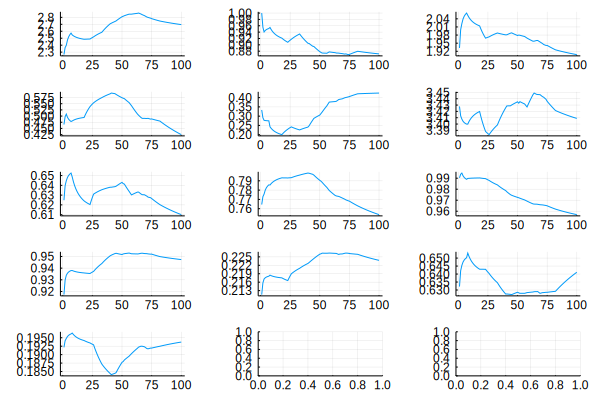

In [36]:
rmean = zeros(Nsim,13)

for i=1:Nsim
    rmean[i,:] = mean(Thetasim[1:i,:],dims=1)
end

plot(1:Nsim,rmean[:,1:13],layout=(5,3),legend=false)

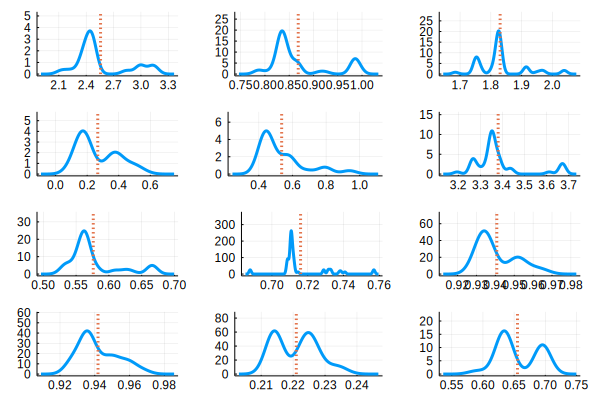

In [37]:
using KernelDensity
using Plots

xmean = zeros(13)
u = zeros(13)
for i=1:13
    xmean[i] = mean(Thetasim[Nburn+1:Nsim,i])
    u[i]    = (1+0.4)*maximum(kde(Thetasim[Nburn+1:Nsim,i]).density);
end

kd1 = kde(Thetasim[Nburn+1:Nsim,1])
kd2 = kde(Thetasim[Nburn+1:Nsim,2])
kd3 = kde(Thetasim[Nburn+1:Nsim,3])
kd4 = kde(Thetasim[Nburn+1:Nsim,4])
kd5 = kde(Thetasim[Nburn+1:Nsim,5])
kd6 = kde(Thetasim[Nburn+1:Nsim,6])
kd7 = kde(Thetasim[Nburn+1:Nsim,7])
kd8 = kde(Thetasim[Nburn+1:Nsim,8])
kd9 = kde(Thetasim[Nburn+1:Nsim,9])
kd10 = kde(Thetasim[Nburn+1:Nsim,10])
kd11 = kde(Thetasim[Nburn+1:Nsim,11])
kd12 = kde(Thetasim[Nburn+1:Nsim,12])
kd13 = kde(Thetasim[Nburn+1:Nsim,13])

lw1 = [3 3]
ls1 = [:solid :dot] 
x1 = [kd1.x xmean[1]*ones(2048)]
y1 = [kd1.density collect(LinRange(0,u[1],2048))]
x2 = [kd2.x xmean[2]*ones(2048)]
y2 = [kd2.density collect(LinRange(0,u[2],2048))]
x3 = [kd3.x xmean[3]*ones(2048)]
y3 = [kd3.density collect(LinRange(0,u[3],2048))]
x4 = [kd4.x xmean[4]*ones(2048)]
y4 = [kd4.density collect(LinRange(0,u[4],2048))]
x5 = [kd5.x xmean[5]*ones(2048)]
y5 = [kd5.density collect(LinRange(0,u[5],2048))]
x6 = [kd6.x xmean[6]*ones(2048)]
y6 = [kd6.density collect(LinRange(0,u[6],2048))]
x7 = [kd7.x xmean[7]*ones(2048)]
y7 = [kd7.density collect(LinRange(0,u[7],2048))]
x8 = [kd8.x xmean[8]*ones(2048)]
y8 = [kd8.density collect(LinRange(0,u[8],2048))]
x9 = [kd9.x xmean[9]*ones(2048)]
y9 = [kd9.density collect(LinRange(0,u[9],2048))]
x10 = [kd10.x xmean[10]*ones(2048)]
y10 = [kd10.density collect(LinRange(0,u[10],2048))]
x11 = [kd11.x xmean[11]*ones(2048)]
y11 = [kd11.density collect(LinRange(0,u[11],2048))]
x12 = [kd12.x xmean[12]*ones(2048)]
y12 = [kd12.density collect(LinRange(0,u[12],2048))]
x13 = [kd13.x xmean[13]*ones(2048)]
y13 = [kd13.density collect(LinRange(0,u[13],2048))]
plot(plot(x1,y1,lw=lw1,ls=ls1),plot(x2,y2,lw=lw1,ls=ls1),plot(x3,y3,lw=lw1,ls=ls1),
    plot(x4,y4,lw=lw1,ls=ls1),plot(x5,y5,lw=lw1,ls=ls1),plot(x6,y6,lw=lw1,ls=ls1),
    plot(x7,y7,lw=lw1,ls=ls1),plot(x8,y8,lw=lw1,ls=ls1),plot(x9,y9,lw=lw1,ls=ls1),
    plot(x10,y10,lw=lw1,ls=ls1),plot(x11,y11,lw=lw1,ls=ls1),plot(x12,y12,lw=lw1,ls=ls1),
#     plot(x13,y13,lw=lw1,ls=ls1),plot(),plot(),
    layout=(4,3),legend=false)

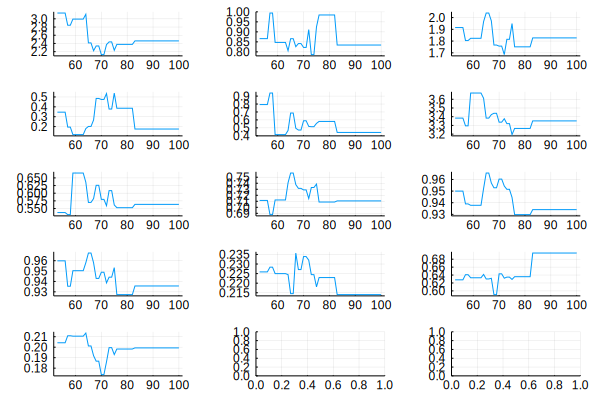

In [38]:
plot(Nburn+1:Nsim,Thetasim[Nburn+1:Nsim,1:13],layout=(5,3),legend=false)

In [ ]:
# # metaparameters
# npara = 13
# ndrop = 1000
# nsim  = 20000+ndrop
# npart = 40000
# seed  = 1234

# c = 0.2
# p0 = mode
# M = Sigma

# diag_M = diag(M)

# lik0 = lik_KF(p0)
# pr0 = prior(p0)
# println([lik0 pr0])

# rng = MersenneTwister(seed)
# e = randn(rng,npara,nsim)
# # Sigma1 = Hermitian(Sigma)
# d = MvNormal(PDMat(c*Sigma1))
# # d = MvNormal(Sigma)
# u = rand(rng,nsim,1)
# acpt = 0
# parasim = zeros(npara,nsim)
# postsim = zeros(nsim)
# p1 = p0

# counter = 1

# for i = 2:nsim
# # i = 2

#     time0 = time()
#     # p0 and p1 are column vectors 1x15: to be fixed
#     # println([size(p0) size(p1) size(diag_M) size(eps[:,i])])
# #     temp = sqrt.(diag_M).*e[:,i]
# #     temp = sqrt.(Sigma)*e[:,i]
#     temp = rand(d,1)
#     p1 = p0 + temp'  
# #     println(p1)
#     lik1 = lik_KF(p1)
#     pr1 = prior(p1)

#     alp = min(1,exp(lik1 + pr1 - lik0 - pr0))

# #     println("")
# #     println("====================================================================")
# #     println(@sprintf("ITERATION %6d", i))
# #     println(@sprintf("Current likelihood  + prior: %10.5f %10.5f", lik0, pr0))
# #     println(@sprintf("Proposed likelihood + prior: %10.5f %10.5f", lik1, pr1))

#     if (u[i,1] <= alp)
#         lik0 = lik1
#         pr0 = pr1
#         p0 = p1
#         acpt = acpt + 1
# #         println("ACCEPTED")
#     end

#     parasim[:,i] = p0
#     postsim[i] = lik0 + pr0
#     time1 = time()
# #     println(@sprintf("Current Acceptance Rate %10.5f", acpt/real(i-1)))
# #     println(@sprintf("iteration %6d   took %10.5f", i, time1-time0))
# #     println("====================================================================")
#     acceptancerate     = acpt/i
#     counter            = counter + 1

#     if (counter==500)
#         println(@sprintf("DRAW NUMBER: %2d",i))
#         println(" ")
#         println(@sprintf("ACCEPTANCE RATE: %6.5f",acceptancerate))
#         println(" ")
# #         println("RECURSIVE AVERAGES")
# #         println("   Tau       Kappa      Psi1       Psi2        rA        piA       gammaQ       rho_R       rho_g       rho_z       sigma_R       sigma_g       sigma_z   ")
# #         println(mean(parasim[:,1:i],dims=2))
# #         println(" ")
        
#         counter = 0
#     end

# end

# println(acpt/nsim*100)